# Implement your own Riemannian Geometry

Lead author: Nina Miolane.

Geomstats provides several Riemannian manifolds in its `geometry` folder. Yet, the manifold that you are interested in might not be available there.

This notebook shows how to use Riemannian geometry on any manifold defined by an immersion into a Euclidean space, such as high-dimensional surfaces immersed in a Euclidean space. 

Specifically, we focus on the case of an embedded manifold $M$ that can be defined by a map 
$f: M \rightarrow \mathbb{R}^n$ 
called the immersion, whose differential $df_x$ is injective for all $x \in M$.

This immersion allows to define the pull-back metric $g$ on $M$, as:

$$g : T_xM \times T_x M \rightarrow \mathbb{R}\\
u, v \rightarrow <df_x.u, df_x.v>$$

where $<,>$ represents the Euclidean inner-product of the embedding space. 

The pull-back metric gives a structure of Riemannian manifold to $M$. In particular, we can compute the Riemannian exp and log maps, the Riemannian distance, the Riemannian parallel transport, etc.

This notebook illustrates the computation of the pull-back metric, using the class `PullbackMetric` from geomstats, on two embedded manifolds:

- the 2-sphere $S^2$ embedded in $\mathbb{R}^3$,

- a surface defined by: $x, y \rightarrow z = x^2 + y^2$ embedded in $\mathbb{R}^3$.

We also illustrate the use of the class`PullbackDiffeoMetric` to compute the pull-back metric induced via a diffeomorphism, on a function that warps the plane $\mathbb{R}^2$

In [1]:
import time

import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as viz
from geomstats.geometry.base import ImmersedSet
from geomstats.geometry.diffeo import Diffeo
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.pullback_metric import (
    PullbackDiffeoMetric,
    PullbackMetric,
)
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

INFO: Using autograd backend


## Immersed manifolds: the example of the 2-sphere

We first consider the simple example of the 2-sphere. We define the immersion of the 2-sphere $S^2$ into the Euclidean space $\mathbb{R}^3$ as follows:
$$
\begin{align}
f : S^2 &\rightarrow \mathbb{R}^3\\
(\theta, \phi) &\mapsto (\cos\phi.\sin\theta, \sin\phi.\sin\theta, \cos\theta)
\end{align}
$$

In [2]:
class SphereIntrinsic(ImmersedSet):
    """Sphere using intrinsic coordinates."""

    def __init__(self, equip=True):
        super().__init__(dim=2, equip=equip)

    def immersion(self, point):
        """Immersion."""
        theta = point[..., 0]
        phi = point[..., 1]
        return gs.stack(
            [
                gs.cos(phi) * gs.sin(theta),
                gs.sin(phi) * gs.sin(theta),
                gs.cos(theta),
            ],
            axis=-1,
        )

    def _define_embedding_space(self):
        return Euclidean(dim=self.dim + 1)

For the purpose of visualizing the results in the embedding space $\mathbb{R}^{3}$, we will need the jacobian of the immersion. Notice that `ImmersedSet` already takes care of it if we want to rely on automatic differentiation.

We use the `PullbackMetric` structure to define the Riemannian metric on $S^2$ from the immersion. 

Note that the Riemannian metric on the sphere is already implemented in Geomstats using closed forms with the class `Hypersphere`. However, this notebook showcases how we can recover the computations of Riemanian geometry by only relying on the immersion.

In [3]:
sphere = SphereIntrinsic(equip=False)

sphere.equip_with_metric(PullbackMetric)

Now, we can access the methods from any Riemannian metric, i.e. the Riemannian exp and log maps, the parallel transport, etc.

We first show the computation of the Riemannian exp map of a tangent vector at a point.

In [4]:
point_a = gs.array([gs.pi / 2.0, -gs.pi / 2.0])
tangent_vec = gs.array([0.0, gs.pi / 3.0])

end_point = sphere.metric.exp(tangent_vec=tangent_vec, base_point=point_a)
print(end_point)

[ 1.57079633 -0.52359878]


And visualize the result of the Riemannian exp map in the embedding space $\mathbb{R}^3$:

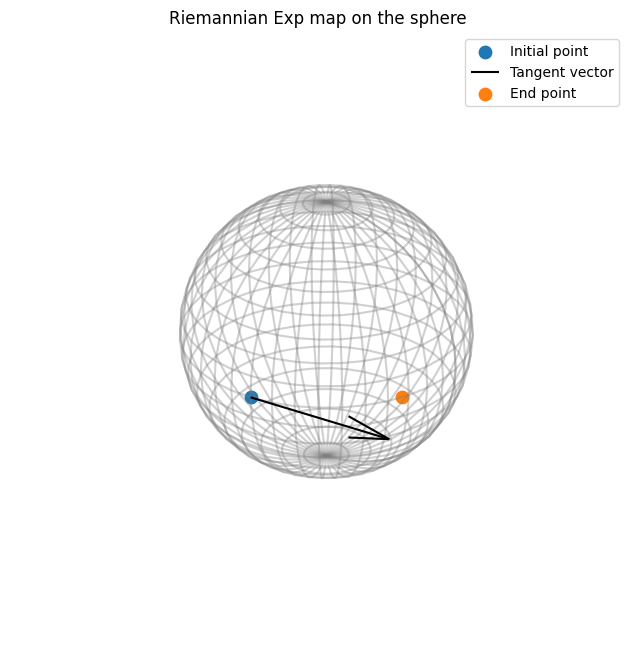

In [5]:
%matplotlib inline

# We immerse the points and the tangent vector in R^3

immersed_point_a = sphere.immersion(point_a)
immersed_tangent_vec = sphere.tangent_immersion(tangent_vec, point_a)
immersed_end_point = sphere.immersion(end_point)

# We plot our results

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

viz.plot(immersed_point_a, ax=ax, space="S2", label="Initial point", s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

viz.plot(immersed_end_point, ax=ax, space="S2", label="End point", s=80)

ax.set_title("Riemannian Exp map on the sphere")
ax.legend()
ax.grid(False)
plt.axis("off");

Next, we show the computation of the parallel transport on the sphere. Note that `step`, `n_steps`, `tol` and `alpha` are integration parameters that control the efficiency-accuracy tradeoff of the computation.

In [6]:
point_a = gs.array([gs.pi / 2.0, -gs.pi / 2.0])
tangent_vec = gs.array([0.0, gs.pi / 3.0])
tangent_vec_to_transport = gs.array([gs.pi / 4.0, gs.pi / 3.0])

time_start = time.perf_counter()


sphere.metric.exp_solver.integrator.step = "euler"
sphere.metric.exp_solver.integrator.n_steps = 1
sphere.metric.log_solver.optimizer.tol = 1e-6

parallel_transport = sphere.metric.ladder_parallel_transport(
    tangent_vec=tangent_vec_to_transport,
    direction=tangent_vec,
    base_point=point_a,
    alpha=1,
)

time_elapsed = time.perf_counter() - time_start
print(f"Computing time for parallel transport: {time_elapsed:5.2f} secs")

display(parallel_transport)

transported_tangent_vec = parallel_transport["transported_tangent_vec"]
end_point = parallel_transport["end_point"]

Computing time for parallel transport:  0.14 secs


{'transported_tangent_vec': array([0.78539816, 1.04719755]),
 'end_point': array([ 1.57079633, -0.52359878]),
 'trajectory': [[]]}

We visualize the result of the parallel transport in the embedding space $\mathbb{R}^3$:

is_tangent =  True


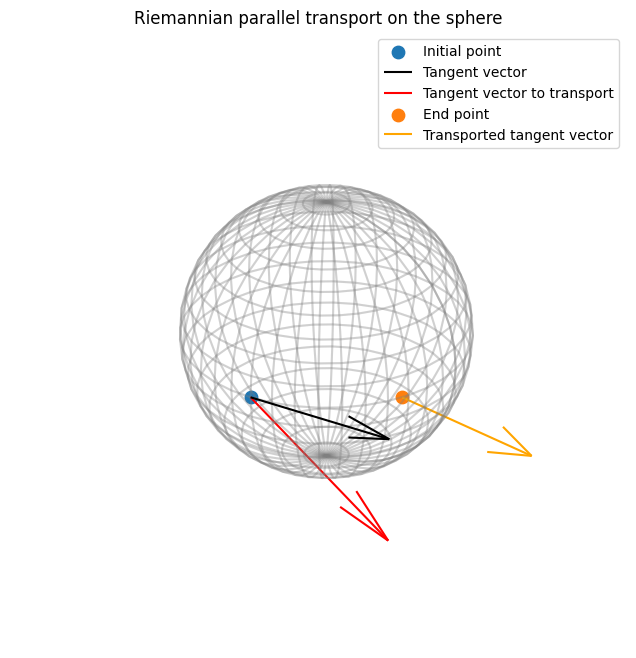

In [7]:
%matplotlib inline

# We first immerse the points and tangent vectors into the embedding space R^3

immersed_point_a = sphere.immersion(point_a)
immersed_end_point = sphere.immersion(end_point)

immersed_tangent_vec = sphere.tangent_immersion(tangent_vec, point_a)
immersed_tangent_vec_to_transport = sphere.tangent_immersion(
    tangent_vec_to_transport, point_a
)
immersed_transported_tangent_vec = sphere.tangent_immersion(
    transported_tangent_vec, end_point
)

# We verify manually that the immersed tangent vector is actually tangent to the sphere
# as the plot can be sometimes misleading. We use the method of the Hypersphere class.

sphere = Hypersphere(dim=2)
is_tangent = sphere.is_tangent(
    immersed_transported_tangent_vec, base_point=immersed_end_point
)
print("is_tangent = ", is_tangent)

# We plot the results

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

viz.plot(immersed_point_a, ax=ax, space="S2", label="Initial point", s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec_to_transport)
arrow.draw(ax, color="red", label="Tangent vector to transport")

viz.plot(immersed_end_point, ax=ax, space="S2", label="End point", s=80)

arrow = viz.Arrow3D(immersed_end_point, vector=immersed_transported_tangent_vec)
arrow.draw(ax, color="orange", label="Transported tangent vector")

ax.set_title("Riemannian parallel transport on the sphere")
ax.legend()
ax.grid(False)
plt.axis("off");

## Immersed manifolds: the example of a surface defined by its graph

We consider the example of a 2D surface immersed in $\mathbb{R}^3$. The surface is defined by its graph:

$$ x, y \rightarrow z = x^2 + y^2$$

which leads to the following immersion into $\mathbb{R}^3$:
$$
\begin{align}
f : S^2 &\rightarrow \mathbb{R}^3\\
(x, y) &\mapsto (x, y, x^2 + y^2)
\end{align}
$$

We first implement the graph and the immersion:

In [8]:
class Surface(ImmersedSet):
    """Surface as immersed set."""

    def __init__(self, equip=True):
        super().__init__(dim=2, equip=equip)

    def _define_embedding_space(self):
        return Euclidean(dim=self.dim + 1)

    def graph(self, x, y):
        """Graph defining surface."""
        return x**2 + y**2

    def immersion(self, point):
        """Immersion."""
        x = point[..., 0]
        y = point[..., 1]
        return gs.transpose(gs.array([x, y, self.graph(x, y)]))

In [9]:
surface = Surface(equip=False)

For the purpose of visualizing the results in the embedding space  ℝ3 , we will need the jacobian of the immersion, which we compute here. Notice that `ImmersedSet` already takes care of it if we want to rely on automatic differentiation.

We also add a utility function to visualization the surface in 3D:

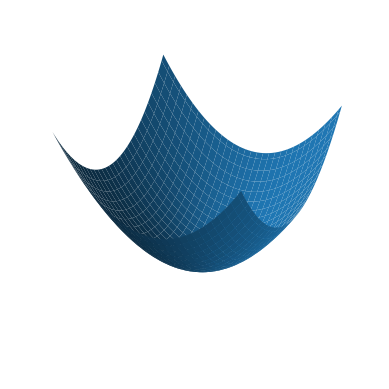

In [10]:
%matplotlib inline


def plot_surface(surface, alpha=1.0, ax=None):
    """Plot surface."""
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

    x = y = gs.arange(-3.0, 3.0, 0.1)
    X, Y = gs.meshgrid(x, y)
    zs = gs.array(surface.graph(gs.flatten(X), gs.flatten(Y)))
    Z = gs.reshape(zs, X.shape)

    ax.plot_surface(gs.to_numpy(X), gs.to_numpy(Y), gs.to_numpy(Z), alpha=alpha)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Zm")
    return ax


ax = plot_surface(surface)
ax.grid(False)
plt.axis("off");

We use the `PullbackMetric` structure to define the Riemannian metric on the surface from the immersion. 

In [11]:
surface.equip_with_metric(PullbackMetric)

Now, we can access the methods from any Riemannian metric, i.e. the Riemannian exp and log maps, the parallel transport, etc.

We show the computation of the Riemannian exp map:

In [12]:
point_a = gs.array([-2.0, -2.0])
tangent_vec = gs.array([0.0, 1.0])

end_point = surface.metric.exp(tangent_vec=tangent_vec, base_point=point_a)
print(end_point)

[-1.82332926 -0.85879156]


And visualize the result:

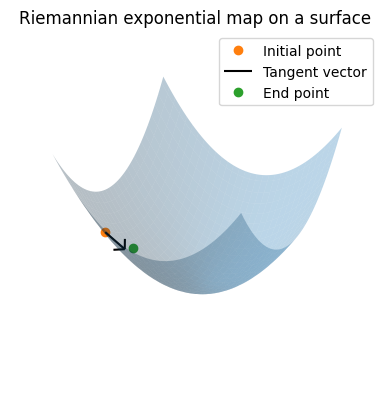

In [13]:
%matplotlib inline

# We first immerse the points and tangent vector into the embedding space R^3

immersed_point_a = surface.immersion(point_a)
immersed_tangent_vec = surface.tangent_immersion(tangent_vec, point_a)
immersed_end_point = surface.immersion(end_point)

two_points = gs.vstack([immersed_point_a, immersed_end_point])

# We plot the results

ax = plot_surface(surface, alpha=0.3)

ax.plot(
    immersed_point_a[0],
    immersed_point_a[1],
    immersed_point_a[2],
    label="Initial point",
    marker="o",
    linestyle="None",
)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

ax.plot(
    immersed_end_point[0],
    immersed_end_point[1],
    immersed_end_point[2],
    label="End point",
    marker="o",
    linestyle="None",
)

ax.set_title("Riemannian exponential map on a surface")
ax.legend()
ax.grid(False)
plt.axis("off");

Next, we show the computation of the parallel transport on the surface. Again, note that `step`, `n_steps`, `tol` and `alpha` are integration parameters that control the efficiency-accuracy tradeoff of the computation.

In [14]:
point_a = gs.array([-2.0, -2.0])
tangent_vec = gs.array([0.0, 1.0])
tangent_vec_to_transport = gs.array([-0.6, 0.6])

time_start = time.perf_counter()

surface.metric.exp_solver.integrator.step = "rk4"
surface.metric.exp_solver.integrator.n_steps = 20
surface.metric.log_solver.optimizer.tol = 1e-14

parallel_transport = surface.metric.ladder_parallel_transport(
    tangent_vec=tangent_vec_to_transport,
    direction=tangent_vec,
    base_point=point_a,
    alpha=2,
)
time_elapsed = time.perf_counter() - time_start
print(f"Computing time for parallel transport: {time_elapsed:5.2f} secs")

display(parallel_transport)

transported_tangent_vec = parallel_transport["transported_tangent_vec"]
end_point = parallel_transport["end_point"]

Computing time for parallel transport:  5.83 secs


{'transported_tangent_vec': array([-0.39054548,  0.74638966]),
 'end_point': array([-1.83662524, -0.86671498]),
 'trajectory': [[]]}

We visualize the result of the parallel transport.

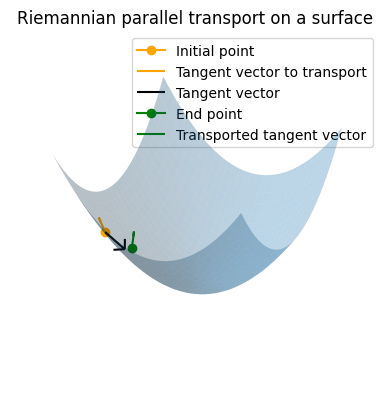

In [15]:
%matplotlib inline

# We first immerse the points and tangent vectors into the embedding space R^3

immersed_point_a = surface.immersion(point_a)
immersed_tangent_vec = surface.tangent_immersion(tangent_vec, point_a)
immersed_tangent_vec_to_transport = surface.tangent_immersion(
    tangent_vec_to_transport, point_a
)
immersed_end_point = surface.immersion(end_point)
immersed_transported_tangent_vec = surface.tangent_immersion(
    transported_tangent_vec, end_point
)

# We plot the results

ax = plot_surface(surface, alpha=0.3)

ax.plot(
    immersed_point_a[0],
    immersed_point_a[1],
    immersed_point_a[2],
    label="Initial point",
    marker="o",
    color="orange",
)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec_to_transport)
arrow.draw(ax, color="orange", label="Tangent vector to transport")

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

ax.plot(
    immersed_end_point[0],
    immersed_end_point[1],
    immersed_end_point[2],
    label="End point",
    marker="o",
    color="green",
)


arrow = viz.Arrow3D(immersed_end_point, vector=immersed_transported_tangent_vec)
arrow.draw(ax, color="green", label="Transported tangent vector")

ax.set_title("Riemannian parallel transport on a surface")
ax.legend()
ax.grid(False)
plt.axis("off");

## Pullback via diffeomorphism: Warping of the plane $\mathbb{R}^2$

We consider the example of a diffeomorphism that warps the plane $\mathbb{R}^2$. 

The warp is given by 
$$
\begin{align}
\varphi : \mathbb{R}^2 &\to \mathbb{R}^2 \\
\vec{x} &\mapsto \vec{u} = \tanh(R_\theta\cdot \vec{x})
\end{align}
$$

where $\theta$ is the angle by which grid lines near the origin are rotated and $\tanh(\cdot)$ is applied element-wise

The inverse diffeomorphism $\varphi^{-1}$ is given by 
$$
\begin{align}
\varphi^{-1} : \mathbb{R}^2 &\to \mathbb{R}^2 \\
\vec{u} &\mapsto \vec{x} = R_{\theta}^{-1}\cdot \tanh^{-1}(\vec{u})
\end{align}
$$

In [17]:
class Warp(Diffeo):
    """Warp diffeomoprhism.

    A diffeomorphism from R^2 to R^2.
    """

    def __init__(self, angle=15):
        self.rot_mat = SpecialOrthogonal(2).matrix_from_rotation_vector(
            gs.array([angle * gs.pi / 180])
        )
        self.inv_rot_mat = SpecialOrthogonal(2).matrix_from_rotation_vector(
            gs.array([-angle * gs.pi / 180])
        )

    def diffeomorphism(self, base_point):
        """Diffeomorphism."""
        transformed_point = gs.einsum("ij,j...->i...", self.rot_mat, base_point)
        return gs.tanh(transformed_point)

    def inverse_diffeomorphism(self, image_point):
        """Inverse diffeomoprhism."""
        transformed_point = gs.einsum("...i", image_point)
        point = gs.arctanh(transformed_point)
        return gs.einsum("ij,j...->i...", self.inv_rot_mat, point)

Set the angle to $\theta = 15^{\circ}$

In [18]:
diffeo = Warp(angle=15)

We visualize the warping of the plane:

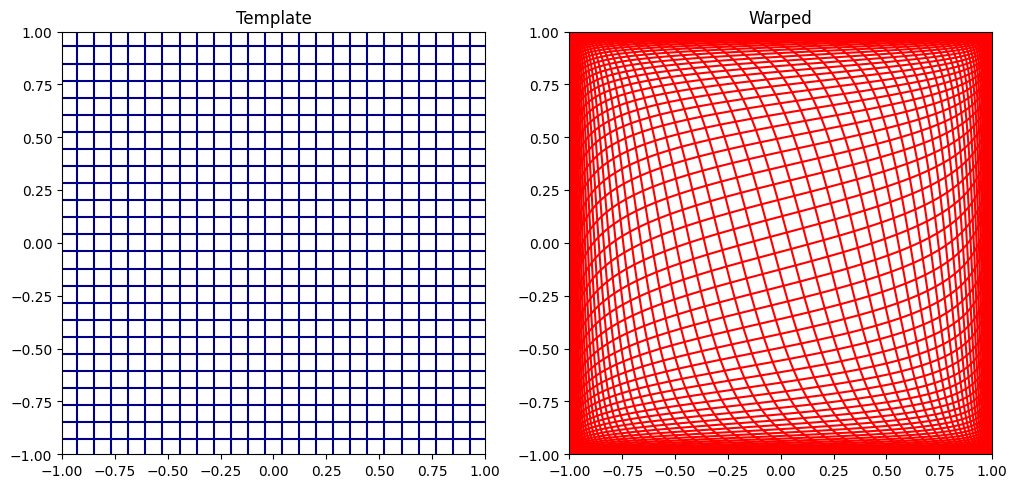

In [19]:
def plot_grid_warped(grid_warped, color, interval=1, show_axis=False):
    """Plot the given warped grid.

    This function plots a given warp grid with the specified color and interval between grid lines.
    It also provides the option to include or exclude axes in the plot.

    Parameters
    ----------
    grid_warped : array-like, shape = [width, height, 2]
        A W x H x 2 dimensional array representing the transformation grid.
    color : str
        A string indicating the color to be used for plotting the grid lines.
    interval : int, optional
        The interval between grid lines, default is 1.
    show_axis : bool, optional
        Whether or not to include axes in the plot, default is False.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The Axes object with the plot drawn onto it.
    """
    if show_axis is False:
        plt.axis("off")
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_aspect("equal")

    for x in range(0, grid_warped.shape[0], interval):
        plt.plot(grid_warped[x, :, 0], grid_warped[x, :, 1], c=color)
    for y in range(0, grid_warped.shape[1], interval):
        plt.plot(grid_warped[:, y, 0], grid_warped[:, y, 1], c=color)
    return ax


x = gs.linspace(-4, 4, 100)
y = gs.linspace(-4, 4, 100)
x_grid, y_grid = gs.meshgrid(x, y)
grid = gs.stack((x_grid, y_grid), axis=-1)
x_grid_warped, y_grid_warped = diffeo.diffeomorphism((x_grid, y_grid))


grid_warped = gs.stack((x_grid_warped, y_grid_warped), axis=-1)

fig = plt.figure(figsize=(12, 12))
ax_template = fig.add_subplot(121)
ax_template = plot_grid_warped(grid, "darkblue", show_axis=True)
ax_warped = fig.add_subplot(122)

ax_warped = plot_grid_warped(grid_warped, "red", show_axis=True)

# Set x and y limits
ax_template.set_xlim((-1, 1))
ax_template.set_ylim((-1, 1))

ax_warped.set_xlim((-1, 1))
ax_warped.set_ylim((-1, 1))

# Ensure that the aspect ratio is the same
# 'equal' means that one unit on the x-axis is equal to one unit on the y-axis
ax_template.set_aspect("equal", adjustable="box")
ax_warped.set_aspect("equal", adjustable="box")

ax_template.set_title("Template")
ax_warped.set_title("Warped");

We use the pullback metric to compute the distance between the origin and $(1,1)$

In [20]:
class PlaneWarpMetric(PullbackDiffeoMetric):
    """Plane warp metric."""

    def __init__(self, space, angle=15):
        diffeo = Warp(angle=angle)
        super().__init__(space=space, image_space=Euclidean(dim=2), diffeo=diffeo)

In [21]:
space = Euclidean(dim=2, equip=False)

space.equip_with_metric(
    PlaneWarpMetric,
    angle=15,
)

In [22]:
point_a = gs.array([0.0, 0.0])
point_b = gs.array([3.0, 4.0])
distance = space.metric.dist(point_a, point_b)
print(distance)

1.3811819105129122
